# Universidad de Buenos Aires
# Deep Learning - TP
# Cohorte 16 - 4to bimestre 2024

El TP comienza al momento de recibir este correo y la ventana de entrega estará abierta hasta **las 20hs del Lunes 21 de octubre**. La resolución es individual. Pueden utilizar los contenidos vistos en clase y otra bibliografía. Si se toman ideas de fuentes externas deben ser correctamente citadas incluyendo el correspondiente link o página de libro.

El formato de entrega debe ser un “link a un colab” (permitir acceso a las siguientes direcciones: alfonsorafel93@gmail.com y lelectronfou@gmail.com) y **se realizará en el siguiente link de google form: [link](https://docs.google.com/forms/d/e/1FAIpQLSc8dLsaaKQxAbtTv5RejE6TxifO_BugdeEU_IdhKl39qMvoMg/viewform?usp=sf_link)**. Tanto los resultados, como el código y las explicaciones deben quedar guardados y visualizables en el colab.

NO ES NECESARIO QUE NOS ENVIEN CORREO AVISANDO DE LA ENTREGA!

**Consideraciones a tener en cuenta:**
- Se entregará 1 solo colab para la totalidad del examen.
- Renombrar el archivo de la siguiente manera: **APELLIDO-NOMBRE-DL-TP Co(numero de cohorte).ipynb**
- Los códigos deben poder ejecutarse.
- Los resultados, cómo el código y las explicaciones deben quedar guardados y visualizables en el correspondiente link.
- Prestar atención a las consignas, responder las preguntas cuando corresponda.


**Condiciones de aprobación**
- Se aprueba con más del 60% del examen bien resuelto de cada parte del TP (Parte 1 y Parte 2).
- La escala de notas empleada por la UBA es aprobado para nota igual o superior a 4.

## Paquetes y funciones auxiliares a utilizar

In [216]:
# ---------------- Paquetes a utilizar ----------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [218]:
def plot_variable_cat(df, column_name, ax, color_palette='Reds_r',
                      grid_interval=5000, orientation='vertical', size_font=7):

    # Frecuencias de las categorías
    value_counts = df[column_name].value_counts()

    # Se determinan si las categorías son numéricas o alfanuméricas y se ordenan
    try:
        sorted_categories = sorted(value_counts.index, key=lambda x: int(x))
    except ValueError:
        sorted_categories = sorted(value_counts.index)

    # Se ordenan las frecuencias por las categorías ordenadas
    value_counts = value_counts.reindex(sorted_categories)

    # Cálculo de los porcentajes
    percentages = (value_counts / value_counts.sum()) * 100

    # Paleta de colores
    cmap = plt.colormaps[color_palette]
    colors = cmap(np.linspace(0.4, 1, len(value_counts)))

    # Orientación del gráfico
    if orientation == 'horizontal':
        # Gráfico de barras horizontales
        bars = ax.barh(value_counts.index, value_counts, color=colors)
        ax.invert_yaxis()  # Invertir el eje Y para que la barra más larga esté arriba
        ax.set_xlabel('Frecuencia')
        ax.set_ylabel(column_name)
        ax.set_xticks(np.arange(0, max(value_counts) + grid_interval, grid_interval))
        ax.grid(axis='x', color='grey', linestyle='--', linewidth=0.5)

        # Se añaden los porcentajes a las barras
        for bar, percentage in zip(bars, percentages):
            ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
                    f'{percentage:.2f}%', va='center', ha='left')

    else:
        # Gráfico de barras verticales
        bars = ax.bar(value_counts.index, value_counts, color=colors)
        ax.set_ylabel('Frecuencia')
        ax.set_xlabel(column_name)
        ax.set_yticks(np.arange(0, max(value_counts) + grid_interval, grid_interval))
        ax.grid(axis='y', color='grey', linestyle='--', linewidth=0.5)

        # Se configuran las etiquetas del eje X ordenadas
        ax.set_xticks(np.arange(len(value_counts)))


        # Añadir los porcentajes a las barras
        for bar, percentage in zip(bars, percentages):
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                    f'{percentage:.2f}%', va='bottom', ha='center', fontsize=size_font)

    ax.set_title(f'Clases variable {column_name}')


In [219]:
# Función para ver valores faltantes de atributos que componen el dataset
def miss_data(df_train, col):

    # Total de filas del df original
    total_filas = len(df_train)

    # Lista para ir agregando los resultados
    resultados = []

    for var in col:
        valores_faltantes = df_train[var].isna().sum()
        proporcion_faltantes = valores_faltantes/total_filas
        resultados.append({
            'Columna': var,
            'Total_Filas': total_filas,
            'Valores_Faltantes': valores_faltantes,
            'Prop_faltantes': proporcion_faltantes
        })

    resultado_df_train = pd.DataFrame(resultados)

    return resultado_df_train

In [220]:
def resumen_categorias(df):
    resumen = []

    # Iterar sobre las columnas del DataFrame original
    for columna in df.columns:
        # Contar las categorías para cada columna
        conteo = df[columna].value_counts()
        total = len(df[columna])

        # Formatear los resultados
        conteo_str = " | ".join([f"{cat} {count}" for cat, count in conteo.items()])
        porcentaje_str = " | ".join([f"{cat} {count / total:.2%}" for cat, count in conteo.items()])

        # Agregar al resumen
        resumen.append([columna, conteo_str, porcentaje_str])

    # Crear el DataFrame de salida
    df_resumen = pd.DataFrame(resumen, columns=['Variable', 'Conteo de Categorías', 'Porcentaje de Categorías'])

    return df_resumen

In [221]:
def recategorizar_columna(df, columna, umbral=0.05):
    """
    Reemplaza las categorías con una frecuencia menor al umbral por 'Otros'.

    Args:
    df: DataFrame de pandas.
    columna: Nombre de la columna a recategorizar.
    umbral: Frecuencia mínima permitida (valor entre 0 y 1). Default = 0.05.

    Returns:
    df: DataFrame con la columna recategorizada.
    """
    # Calculamos la frecuencia relativa de cada categoría
    frecuencias = df[columna].value_counts(normalize=True)

    # Identificamos las categorías con menos frecuencia que el umbral
    categorias_a_reemplazar = frecuencias[frecuencias < umbral].index

    # Reemplazamos las categorías poco frecuentes con 'Otros'
    df[columna] = df[columna].apply(lambda x: 'Otros' if x in categorias_a_reemplazar else x)

    return df

# Parte 1
Descargar el dataset del siguiente link: https://drive.google.com/file/d/1X8_G5BpQMi-Nnbtms2RL8lcWSxzD8ixd/view?usp=sharing. El dataset son compras de productos que diferentes clientes realizaron durante un black sales. El dataset contiene información sobre las transacciones y el objetivo es poder utilizarlo para crear diferentes modelos que puedan predecir cuánto un cliente está dispuesto a gastar en un producto en el futuro.
- a) Analizar y preparar el dataset.

Particularmente para los puntos b), c) y d) vamos a tratar este problema como una clasificación donde queremos averiguar si el cliente pertenece al grupo 0 (gasta menos de 5000), al grupo 1 (gasta entre 5000 y 10000), al grupo 2 (gasta entre 10000 y 15000) o al grupo 3 (gasta más de 15000).
- b) Entrenar un modelo de deep learning que no utilice embeddings, **descartando el `product_id` y `user_id`** . Graficar las evoluciones de la funcion de costo y la métrica de validación. Usar capas de regularización en caso de considerar necesario. Explicar resultados obtenidos.
- c)	Entrenar un modelo de deep learning que utilice **2 capas de embeddings**, una para los productos y otra para los usuarios. Graficar las evoluciones de la función de costo y la métrica de validación. Usar capas de regularización en caso de considerar necesario. Explicar resultados obtenidos.
- d) Para el modelo del punto c) implementar una funcion que a reciba un id de usuario y sugiera **n** cantidad usuarios que tuvieron un comportamiento de compras similar.

Para el punto e) vamos a considerar un problema de regresion, donde la salida es cuanto gasto el cliente:
- e)	Entrenar un de deep learning que utilice **2 capas de embeddings**, una para los productos y otra para los usuarios. Graficar las evoluciones de la funcion de costo y la metrica de validacion. Usar capas de regularizacion en caso de considerar necesario. Explicar resultados obtenidos.
- f) Para el mejor modelo obtenido en el apartado e) elegir al menos 2 hiperparámetros para tunear. Explicar el metodo utilizado y los resultados obtenidos.



## Resolución Parte 1

### Parte (a)

Analizar y preparar el dataset.

Particularmente para los puntos b), c) y d) vamos a tratar este problema como una clasificación donde queremos averiguar si el cliente pertenece al grupo 0 (gasta menos de 5000), al grupo 1 (gasta entre 5000 y 10000), al grupo 2 (gasta entre 10000 y 15000) o al grupo 3 (gasta más de 15000).

In [222]:
# Carga de datos

id = '1X8_G5BpQMi-Nnbtms2RL8lcWSxzD8ixd'
url = f'https://drive.google.com/uc?id={id}'
datos = pd.DataFrame(pd.read_csv(url))

In [223]:
# Vista rápida de datos para controlar que hayan cargado bien
datos.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [225]:
# Información general de los datos
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


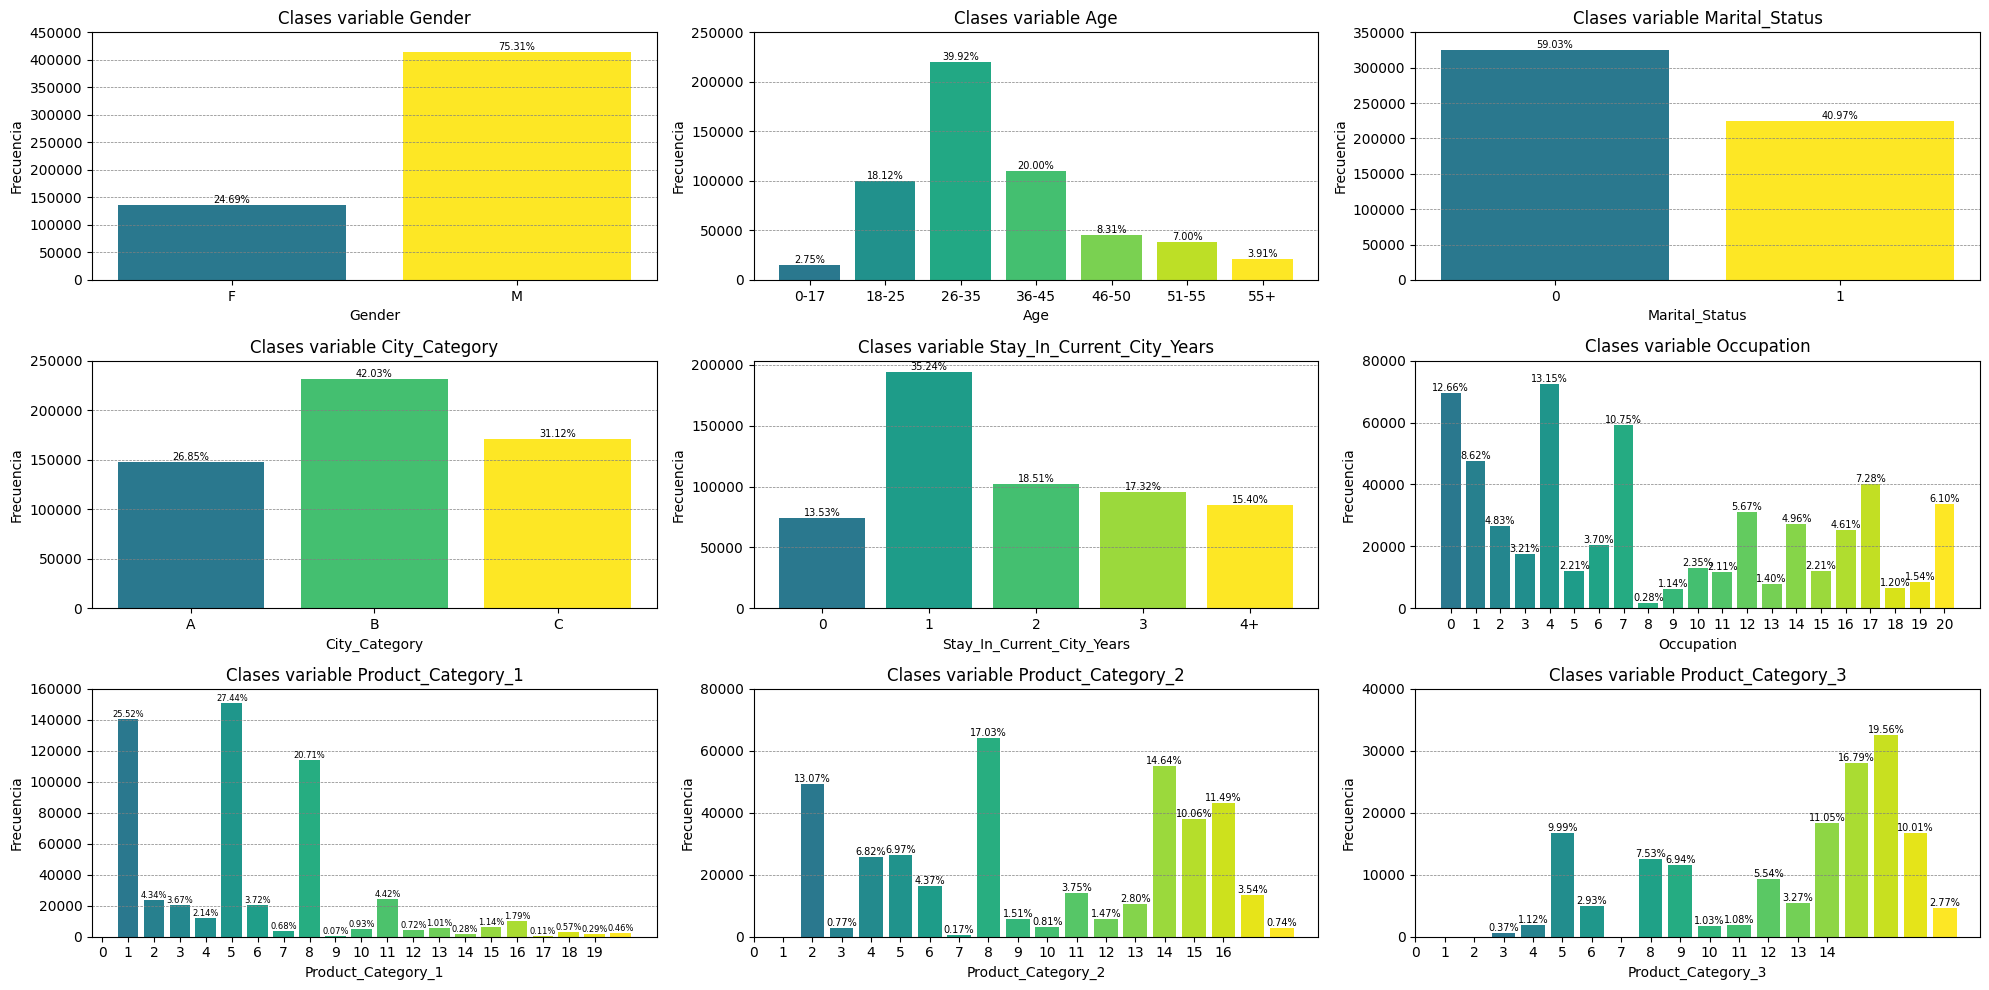

In [226]:
# Plots de variables categóricas
fig, axs = plt.subplots(3, 3, figsize=(20, 10))

plot_variable_cat(datos, 'Gender', ax = axs[0,0], color_palette='viridis', grid_interval=50000)
plot_variable_cat(datos, 'Age', ax = axs[0,1], color_palette='viridis', grid_interval=50000)
plot_variable_cat(datos, 'Marital_Status', ax = axs[0,2], color_palette='viridis', grid_interval=50000)
plot_variable_cat(datos, 'City_Category', ax = axs[1,0], color_palette='viridis', grid_interval=50000)
plot_variable_cat(datos, 'Stay_In_Current_City_Years', ax = axs[1,1], color_palette='viridis', grid_interval=50000)
plot_variable_cat(datos, 'Occupation', ax = axs[1,2], color_palette='viridis', grid_interval=20000)
plot_variable_cat(datos, 'Product_Category_1', ax = axs[2,0], color_palette='viridis', grid_interval=20000, size_font = 6)
plot_variable_cat(datos, 'Product_Category_2', ax = axs[2,1], color_palette='viridis', grid_interval=20000)
plot_variable_cat(datos, 'Product_Category_3', ax = axs[2,2], color_palette='viridis', grid_interval=10000)

plt.tight_layout()
plt.show()

#### Procesamiento de datos

Hay que armar las categorías específicas según el gasto del cliente ($GC$), para poder entrenar / validar el modelo que prediga esto.
- **Cat. 0**: $GC < 5000$
- **Cat. 1**: $5000 \leq GC < 10000$
- **Cat. 2**: $10000 \leq GC < 15000$
- **Cat. 3**: $15000 \leq GC$

In [227]:
# Se arman las categorías especificadas, ademas de calcular las proporciones de cada clase
# y un ajuste de los pesos (tratando de dar más peso a las clases menos presente)

datos['GC_Category'] = pd.cut(datos['Purchase'], bins=[0, 5000, 10000, 15000, np.inf], labels=[0, 1, 2, 3])
GC_count = pd.DataFrame(datos['GC_Category'].value_counts().sort_index())
GC_count['prop'] = (GC_count / GC_count.sum())
GC_count['aj_weight'] = 1/GC_count['prop']
GC_count['aj_weight'] = GC_count['aj_weight']/GC_count['aj_weight'].sum()
GC_count

,count,prop,aj_weight
GC_Category,,,
0,94923,0.172566,0.292502
1,265695,0.483022,0.104500
2,78927,0.143486,0.351782
3,110523,0.200926,0.251216


In [228]:
list(GC_count['aj_weight'])

[0.29250164224307995,
 0.1045000221556291,
 0.3517824494360596,
 0.25121588616523144]

Se observan datos faltantes, específicamente en 2 variables: `Product_Category_2` y `Product_Category_3`. Como se ve abajo, son una proporción relativamente grande con respecto a los datos, por lo que hay que darle algún tratamiento. Se le asigna una clase residual por el momento (`99`).

In [229]:
miss_data(datos, datos.columns)[miss_data(datos, datos.columns)['Prop_faltantes'] > 0]


,Columna,Total_Filas,Valores_Faltantes,Prop_faltantes
9,Product_Category_2,550068,173638,0.315666
10,Product_Category_3,550068,383247,0.696727


In [230]:
# Se asigna '99' ("sin dato") a valores faltantes
datos['Product_Category_2'] = datos['Product_Category_2'].fillna(99)
datos['Product_Category_3'] = datos['Product_Category_3'].fillna(99)

Si bien las variables `Occupation`, `Marital Status`, `Product_Category_1`, `Product_Category_2` y `Product_Category_3`, están como tipo `int64` y `float64`, lo que terminan representando son categorías, así que se definen de esta manera para poder convertir en variables binarias luego mediante One-Hot-Encoding.

In [231]:
# Preprocesamiento de float64 a int64
datos['Product_Category_2'] = datos['Product_Category_2'].astype('int64')
datos['Product_Category_3'] = datos['Product_Category_3'].astype('int64')

# Lista de columnas a convertir en categóricas
cat_variables = [
    'Occupation',
    'Marital_Status',
    'Product_Category_1',
    'Product_Category_2',
    'Product_Category_3'
]

# Convertir las columnas a tipo 'category'
datos[cat_variables] = datos[cat_variables].astype('category')

In [232]:
# Nos quedamos solo con las variables relevantes para el modelo
# - En este caso no se utilizan embeddings, así que se descarta User_ID y Product_ID (pero se guardan para más adelante)
# - Purchase se transformó en variable categórica: GC_Category para manejar las clases de salida

embeddings = datos[['User_ID', 'Product_ID']]
datos_modelo = datos.drop(columns=['User_ID', 'Product_ID', 'Purchase'])


In [233]:
# Aplicamos la función a las columnas relevantes con un umbral del 5%
#datos_modelo = recategorizar_columna(datos_modelo, 'Occupation', umbral=0.02)
#datos_modelo = recategorizar_columna(datos_modelo, 'Product_Category_1', umbral=0.02)
#datos_modelo = recategorizar_columna(datos_modelo, 'Product_Category_2', umbral=0.02)
#datos_modelo = recategorizar_columna(datos_modelo, 'Product_Category_3', umbral=0.02)

In [234]:
# Label encoding para las variables que tienen un orden: "Age" | "Stay_In_Current_City_Years"
from sklearn.preprocessing import LabelEncoder

# Inicializamos el codificador
le = LabelEncoder()
datos['Age'] = le.fit_transform(datos['Age'])
datos['Stay_In_Current_City_Years'] = le.fit_transform(datos['Stay_In_Current_City_Years'])

# Se pasa a variables dummy todas las variables
type_dummies = pd.get_dummies(datos_modelo.drop(columns = ['Age','Stay_In_Current_City_Years','GC_Category']))
type_dummies

,Gender_F,Gender_M,Occupation_0,Occupation_1,Occupation_2,Occupation_3,Occupation_4,Occupation_5,Occupation_6,Occupation_7,...,Product_Category_3_10,Product_Category_3_11,Product_Category_3_12,Product_Category_3_13,Product_Category_3_14,Product_Category_3_15,Product_Category_3_16,Product_Category_3_17,Product_Category_3_18,Product_Category_3_99
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550063,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
550064,True,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
550065,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
550066,True,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [235]:
type_dummies.shape

(550068, 82)

In [236]:
type_dummies.columns

Index(['Gender_F', 'Gender_M', 'Occupation_0', 'Occupation_1', 'Occupation_2',
       'Occupation_3', 'Occupation_4', 'Occupation_5', 'Occupation_6',
       'Occupation_7', 'Occupation_8', 'Occupation_9', 'Occupation_10',
       'Occupation_11', 'Occupation_12', 'Occupation_13', 'Occupation_14',
       'Occupation_15', 'Occupation_16', 'Occupation_17', 'Occupation_18',
       'Occupation_19', 'Occupation_20', 'City_Category_A', 'City_Category_B',
       'City_Category_C', 'Marital_Status_0', 'Marital_Status_1',
       'Product_Category_1_1', 'Product_Category_1_2', 'Product_Category_1_3',
       'Product_Category_1_4', 'Product_Category_1_5', 'Product_Category_1_6',
       'Product_Category_1_7', 'Product_Category_1_8', 'Product_Category_1_9',
       'Product_Category_1_10', 'Product_Category_1_11',
       'Product_Category_1_12', 'Product_Category_1_13',
       'Product_Category_1_14', 'Product_Category_1_15',
       'Product_Category_1_16', 'Product_Category_1_17',
       'Product_Ca

In [237]:
datos_prueba = pd.concat([type_dummies, datos[['Age','Stay_In_Current_City_Years','GC_Category']]], axis = 1)
datos_prueba = datos_prueba.drop(columns = ['Gender_F','Marital_Status_0','City_Category_C'])

In [238]:
datos_prueba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 82 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   Gender_M                    550068 non-null  bool    
 1   Occupation_0                550068 non-null  bool    
 2   Occupation_1                550068 non-null  bool    
 3   Occupation_2                550068 non-null  bool    
 4   Occupation_3                550068 non-null  bool    
 5   Occupation_4                550068 non-null  bool    
 6   Occupation_5                550068 non-null  bool    
 7   Occupation_6                550068 non-null  bool    
 8   Occupation_7                550068 non-null  bool    
 9   Occupation_8                550068 non-null  bool    
 10  Occupation_9                550068 non-null  bool    
 11  Occupation_10               550068 non-null  bool    
 12  Occupation_11               550068 non-null  bool    
 13 

In [239]:
# FLAG -- POR CORRELACION NO SE VE NADA, NO SE PUEDE USAR PARA VER VARIABLES SIGNIFICATIVAS
'''
correlation_matrix = datos_prueba.corr()

plt.figure(figsize=(10, 7))

# Heatmap
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap="flare")
plt.title('Matriz de Correlación de las Variables')

plt.show()
'''

'\ncorrelation_matrix = datos_prueba.corr()\n\nplt.figure(figsize=(10, 7))\n\n# Heatmap\nsns.heatmap(correlation_matrix, annot=True, fmt=\'.2f\', cmap="flare")\nplt.title(\'Matriz de Correlación de las Variables\')\n\nplt.show()\n'

In [240]:
# FLAG -- SE PUEDE ENTRENAR MODELO PARA IMPORTANCIA DE VARIABLES, PERO NO SE VE TAMPOCO NADA
# SE HACE MUCHA REFERENCIA A PRODUCTOS_CATEGORIA_1
'''
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split

def seleccionar_variables_rf(df, target_column, modelo='clasificacion', n_estimators=100):
    # Separar variables predictoras y la variable objetivo
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Dividir los datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Elegir el modelo de Random Forest adecuado (clasificación o regresión)
    if modelo == 'clasificacion':
        rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    elif modelo == 'regresion':
        rf = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    else:
        raise ValueError("El parámetro 'modelo' debe ser 'clasificacion' o 'regresion'.")

    # Entrenar el modelo
    rf.fit(X_train, y_train)

    # Obtener la importancia de las variables
    importances = rf.feature_importances_
    feature_names = X.columns

    # Crear un DataFrame con las importancias y ordenarlas
    importancia_df = pd.DataFrame({'Variable': feature_names, 'Importancia': importances})
    importancia_df = importancia_df.sort_values(by='Importancia', ascending=False)

    return importancia_df

# Ejemplo de uso
# Asume que 'df' es tu DataFrame y 'target' es la columna objetivo
# Cambia 'target' por la columna objetivo de tu DataFrame
resultado = seleccionar_variables_rf(df=datos_prueba, target_column='GC_Category', modelo='clasificacion')
print(resultado)
'''

'\nfrom sklearn.ensemble import RandomForestClassifier, RandomForestRegressor\nfrom sklearn.model_selection import train_test_split\n\ndef seleccionar_variables_rf(df, target_column, modelo=\'clasificacion\', n_estimators=100):\n    # Separar variables predictoras y la variable objetivo\n    X = df.drop(columns=[target_column])\n    y = df[target_column]\n\n    # Dividir los datos en entrenamiento y prueba\n    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)\n\n    # Elegir el modelo de Random Forest adecuado (clasificación o regresión)\n    if modelo == \'clasificacion\':\n        rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)\n    elif modelo == \'regresion\':\n        rf = RandomForestRegressor(n_estimators=n_estimators, random_state=42)\n    else:\n        raise ValueError("El parámetro \'modelo\' debe ser \'clasificacion\' o \'regresion\'.")\n\n    # Entrenar el modelo\n    rf.fit(X_train, y_train)\n\n    # Obtener

#### Procesamiento del dataset para el modelo


In [241]:
datos_prueba = datos_prueba.astype('float64')
y = datos_prueba['GC_Category']
x = datos_prueba.drop(columns = ['GC_Category'])

In [242]:
x = x.to_numpy()
y = y.to_numpy()

In [243]:
x.shape, y.shape

((550068, 81), (550068,))

In [244]:
# Normalización min-max
x_norm = (x - np.min(x, axis=0)) / (np.max(x, axis=0 ) - np.min(x, axis=0))

In [245]:
# ---------------- Split de datos para entrenamiento | validación ----------------

# from sklearn.model_selection import train_test_split

# x_train, x_valid, y_train, y_valid = train_test_split(x_norm, y, test_size=0.15, random_state=42)


#SMOTE
#from imblearn.over_sampling import SMOTE
#smote = SMOTE(random_state=42)
#x_train, y_train = smote.fit_resample(x_train, y_train)

# Divido el dataset
random_state = np.random.RandomState(seed=42)
idx = random_state.permutation(x_norm.shape[0])
train_idx = idx[0:int(0.85*len(idx))]
valid_idx = idx[int(0.85*len(idx)):]

x_train = x_norm[train_idx]
y_train = y[train_idx]
x_valid = x_norm[valid_idx]
y_valid = y[valid_idx]

n_train = x_train.shape[0]
n_valid = x_valid.shape[0]

In [246]:
from collections import Counter
Counter(y_train)

Counter({1.0: 226006, 3.0: 93763, 0.0: 80629, 2.0: 67159})

### Parte (b)

Entrenar un modelo de deep learning que no utilice embeddings, **descartando el `product_id` y `user_id`** . Graficar las evoluciones de la funcion de costo y la métrica de validación. Usar capas de regularización en caso de considerar necesario. Explicar resultados obtenidos.

In [247]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn import metrics

In [248]:
# Para setear el device
device = "cpu"
if torch.cuda.is_available():
  device = "cuda:0"

device

'cpu'

In [249]:
# Pytorch necesita de una clase de dataset que extienda de torch.utils.data.Dataset
# Esta clase dataset debe sobreescribir los métodos init, len y getitem
class MyDataset(Dataset):

  #__init__ guarda el dataset en una variable de clase
  def __init__(self, x, y):
    self.x = x
    self.y = y

  # __len__ define el comportamiento de la función len() sobre el objeto
  def __len__(self):
    return self.x.shape[0]

  # __getitem__ define el comportamiento de los []
  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

In [250]:
# Creo el dataset de entrenamiento
train_ds = MyDataset(x=x_train, y=y_train)

In [251]:
# Vemos como queda una línea del entrenamiento
train_ds[4]

(array([1.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [252]:
# Creo el dataset de validación
valid_ds = MyDataset(x_valid, y_valid)

In [253]:
# Testeo funcionamiento de __len__
# Está ok, es un 15% del total de registros
len(valid_ds)

82511

In [254]:
# Pytorch utiliza DataLoader para entregar los dataset de a batches
train_dataloader = DataLoader(train_ds, batch_size = 64, shuffle= True)
valid_dataloader = DataLoader(valid_ds, batch_size = 64)

In [255]:
x.shape, y.shape

((550068, 81), (550068,))

In [257]:
class NNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_1 = torch.nn.Linear(in_features=81, out_features=128, bias=True)
        self.batch_norm1 = torch.nn.BatchNorm1d(128)
        self.relu_1 = torch.nn.ReLU()
        self.dropout_1 = torch.nn.Dropout(0.1)
        self.linear_2 = torch.nn.Linear(in_features=128, out_features=64, bias=True)
        self.batch_norm2 = torch.nn.BatchNorm1d(64)
        self.relu_2 = torch.nn.ReLU()
        self.dropout_2 = torch.nn.Dropout(0.1)
        self.linear_3 = torch.nn.Linear(in_features=64, out_features=4, bias=True)  # 4 clases

    def forward(self, x):
        x = self.linear_1(x)
        x = self.batch_norm1(x)
        x = self.relu_1(x)
        x = self.dropout_1(x)
        x = self.linear_2(x)
        x = self.batch_norm2(x)
        x = self.relu_2(x)
        x = self.dropout_2(x)
        x = self.linear_3(x)
        return x

# Instanciamos la red y la copiamos al dispositivo
nnet = NNet().to(device)

# Definimos la loss y el optimizador
loss_function = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.002)

epochs = 200

train_loss_by_epoch=[]
valid_loss_by_epoch=[]
train_metric_by_epoch=[]
valid_metric_by_epoch=[]

# Para implementar un early stopping
best_loss = float('inf')
patience = 5  # Número de épocas sin mejora antes de detener
step = 0


# Entrenamiento
for epoch in range(epochs):
    nnet.train()
    epoch_loss = 0
    epoch_y, epoch_y_hat = [], []

    for i, data in enumerate(train_dataloader):
        x_batch, y_batch = data
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).long()  # Etiquetas como enteros

        optimizer.zero_grad()
        nnet_output = nnet(x_batch)
        loss = loss_function(nnet_output, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_y += list(y_batch.cpu().numpy())
        epoch_y_hat += list(torch.argmax(nnet_output, dim=1).cpu().numpy())

    # Calculo la media de la loss
    epoch_loss = epoch_loss / len(train_dataloader)
    # Almaceno la loss de la epoch para graficar
    train_loss_by_epoch.append(epoch_loss)
    # Cálculo la métrica de la epoch
    train_metric = metrics.accuracy_score(epoch_y, epoch_y_hat)
    train_metric_by_epoch.append(train_metric)

    # Validación
    nnet.eval()
    valid_loss = 0
    valid_y, valid_y_hat = [], []

    with torch.no_grad():
        for i, data in enumerate(valid_dataloader):
            x_batch, y_batch = data
            x_batch = x_batch.to(device).float()
            y_batch = y_batch.to(device).long()

            # Paso forward
            nnet_output = nnet(x_batch)
            loss = loss_function(nnet_output, y_batch)
            valid_loss += loss.item()

            valid_y += list(y_batch.cpu().numpy())
            valid_y_hat += list(torch.argmax(nnet_output, dim=1).cpu().numpy())

    valid_loss = valid_loss / len(valid_dataloader)
    # Almaceno la loss de la epoch para graficar
    valid_loss_by_epoch.append(valid_loss)
    valid_metric = metrics.accuracy_score(valid_y, valid_y_hat)
    valid_metric_by_epoch.append(valid_metric)

    print(f"Epoch {epoch} | Train/Valid loss: {epoch_loss:.4f} / {valid_loss:.4f} | "
          f"Train/Valid Metric: {train_metric:.4f} / {valid_metric:.4f}")

    # Early stopping
    if np.round(valid_loss,4) < best_loss:
        best_loss = np.round(epoch_loss,4)
        patience_counter = 0  # Reinicia el contador
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Detenido por early stopping.")
        break

Epoch 0 | Train/Valid loss: 0.7199 / 0.7026 | Train/Valid Metric: 0.7101 / 0.7157
Epoch 1 | Train/Valid loss: 0.7092 / 0.7002 | Train/Valid Metric: 0.7127 / 0.7162
Epoch 2 | Train/Valid loss: 0.7065 / 0.7017 | Train/Valid Metric: 0.7133 / 0.7158
Epoch 3 | Train/Valid loss: 0.7048 / 0.6986 | Train/Valid Metric: 0.7137 / 0.7154
Epoch 4 | Train/Valid loss: 0.7036 / 0.7004 | Train/Valid Metric: 0.7142 / 0.7170
Epoch 5 | Train/Valid loss: 0.7023 / 0.6974 | Train/Valid Metric: 0.7146 / 0.7169
Epoch 6 | Train/Valid loss: 0.7017 / 0.6971 | Train/Valid Metric: 0.7147 / 0.7174
Epoch 7 | Train/Valid loss: 0.7012 / 0.6965 | Train/Valid Metric: 0.7152 / 0.7167
Epoch 8 | Train/Valid loss: 0.7004 / 0.6957 | Train/Valid Metric: 0.7148 / 0.7175
Epoch 9 | Train/Valid loss: 0.7001 / 0.6951 | Train/Valid Metric: 0.7151 / 0.7169
Epoch 10 | Train/Valid loss: 0.6994 / 0.6954 | Train/Valid Metric: 0.7151 / 0.7172
Epoch 11 | Train/Valid loss: 0.6989 / 0.6961 | Train/Valid Metric: 0.7155 / 0.7169
Epoch 12 | Tra

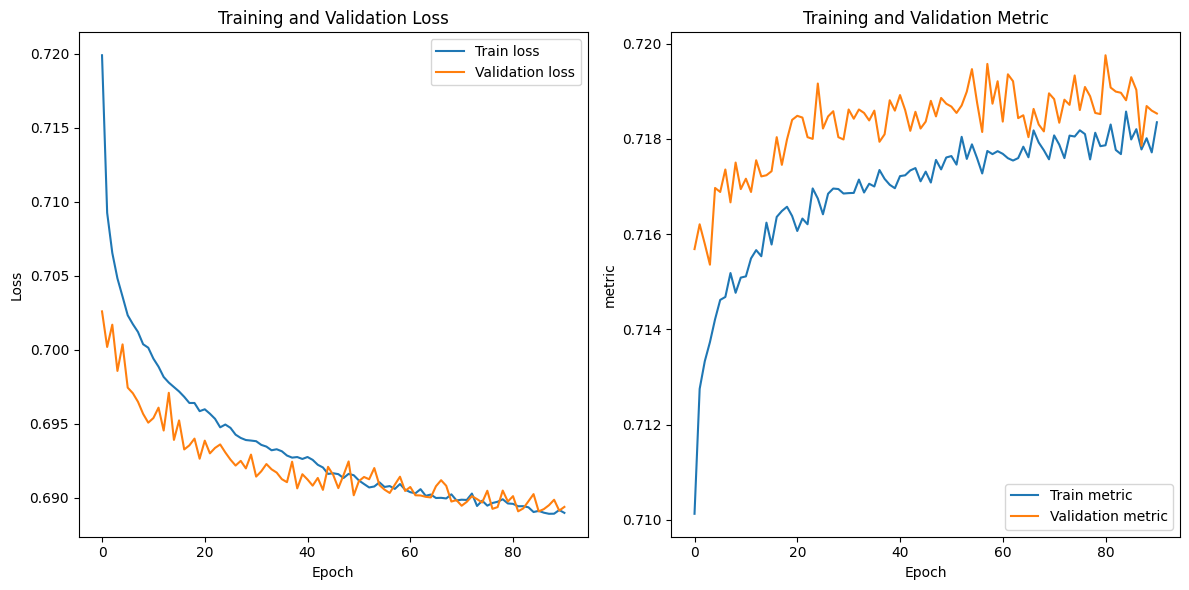

In [258]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Training and Validation Loss
axes[0].plot(train_loss_by_epoch, label="Train loss")
axes[0].plot(valid_loss_by_epoch, label="Validation loss")
axes[0].legend()
axes[0].set_title("Training and Validation Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")

# Training and Validation f1-score
axes[1].plot(train_metric_by_epoch, label="Train metric")
axes[1].plot(valid_metric_by_epoch, label="Validation metric")
axes[1].legend()
axes[1].set_title("Training and Validation Metric")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("metric")

plt.tight_layout()
plt.show()

**Plot de Training | Validation Loss**

 - **Train loss:** la pérdida en entrenamiento desciende constantemente a lo largo de las épocas, lo que indica que el modelo está aprendiendo de los datos de entrenamiento.
- **Validation loss:** la pérdida de validación también disminuye inicialmente y luego empieza a estabilizarse en un valor similar a la pérdida de entrenamiento, con algunas fluctuaciones. No hay un aumento significativo, por lo que el modelo corta antes de las épocas fijadas (200), debido al early stopping, lo que indica que el modelo está generalizando bien a los datos de validación. No se aprecia sobreajuste en este gráfico, por lo que estaría ajustando bien.

**Plot de Training | Validation Metric (En este caso *accuracy*)**
- **Train Accuracy:**  mejora de manera constante hasta cierto punto, donde parece estabilizarse. Esto puede indicar que el modelo está aprendiendo bien y mejorando su capacidad de predecir correctamente en los datos de entrenamiento.
- **Valid Accuracy:** inicialmente mejora más rápido que la métrica de entrenamiento y luego oscila alrededor de un valor similar a la métrica de entrenamiento (parece estar convergiendo). Las fluctuaciones en la métrica de validación relativamente pequeñas, el modelo no parece estar sobreajustando significativamente.

### Parte (c)

Entrenar un modelo de deep learning que utilice **2 capas de embeddings**, una para los productos y otra para los usuarios. Graficar las evoluciones de la función de costo y la métrica de validación. Usar capas de regularización en caso de considerar necesario. Explicar resultados obtenidos.

In [259]:
# Vemos cuantas categorías únicas tiene cada 

# Usuarios
print(len(embeddings['User_ID'].unique()))

# Productos
print(len(embeddings['Product_ID'].unique()))

5891
3631


In [261]:
# Renombramos las variables para tenerlas bien claras después en el modelo
user_id = embeddings['User_ID']
product_id = embeddings['Product_ID']

In [263]:
# Hacemos un head para ver que estés cargadas ok
product_id.head()

0    P00069042
1    P00248942
2    P00087842
3    P00085442
4    P00285442
Name: Product_ID, dtype: object

In [265]:
# Transformamos user_id / product_id a indices (idx) consecutivos para utilizar embeddings

user_id_to_idx = {value:i for i,value in enumerate(embeddings['User_ID'].unique())}
product_id_to_idx = {value:i for i,value in enumerate(embeddings['Product_ID'].unique())}

# Vector de vendor_idx en el dataset
user_idx = np.array([user_id_to_idx[value] for value in user_id])
product_idx = np.array([product_id_to_idx[value] for value in product_id])

In [266]:
# Dividimos el vector user_idx / product_idx en entrenamiento y validación
# (según los indices utilizados antes, para que siga misma muestra)

user_idx_train = user_idx[train_idx]
user_idx_valid = user_idx[valid_idx]

product_idx_train = product_idx[train_idx]
product_idx_valid = product_idx[valid_idx]

In [267]:
# Clase Dataset de Pytorch con embeddings
class MyDatasetWithEmbddings(Dataset):

  def __init__(self, x, user_idx, product_idx, y):
    self.x = x
    self.user_idx = user_idx
    self.product_idx = product_idx
    self.y = y

  def __len__(self):
    return self.x.shape[0]

  def __getitem__(self, idx):
    return self.x[idx], self.user_idx[idx], self.product_idx[idx], self.y[idx]

In [268]:
train_ds_embeddings = MyDatasetWithEmbddings(x_train, user_idx_train, product_idx_train, y_train)
valid_ds_embeddings = MyDatasetWithEmbddings(x_valid, user_idx_valid, product_idx_valid, y_valid)

In [269]:
train_dataloader_emb = DataLoader(train_ds_embeddings, batch_size =64, shuffle= True)
valid_dataloader_emb = DataLoader(valid_ds_embeddings, batch_size=64)

In [276]:
# Creamos la clase de la red
class NNetWithEmbeddings(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embeddings1 = torch.nn.Embedding(num_embeddings=5891, embedding_dim=5)
        self.embeddings2 = torch.nn.Embedding(num_embeddings=3631, embedding_dim=5)
        self.linear_1 = torch.nn.Linear(in_features=81+5+5, out_features=128, bias=True)
        self.batch_norm1 = torch.nn.BatchNorm1d(128)
        self.relu_1 = torch.nn.ReLU()
        self.dropout_1 = torch.nn.Dropout(0.4)
        self.linear_2 = torch.nn.Linear(in_features=128, out_features=64, bias=True)
        self.batch_norm2 = torch.nn.BatchNorm1d(64)
        self.relu_2 = torch.nn.ReLU()
        self.dropout_2 = torch.nn.Dropout(0.4)
        self.linear_3 = torch.nn.Linear(in_features=64, out_features=4, bias=True)  # 4 clases

    def forward(self, x, user_idx, product_idx):
        embeddings_outputs1 = self.embeddings1(user_idx)
        embeddings_outputs2 = self.embeddings2(product_idx)
        x = torch.cat([x, embeddings_outputs1, embeddings_outputs2], dim=1)
        x = self.linear_1(x)
        x = self.batch_norm1(x)
        x = self.relu_1(x)
        x = self.dropout_1(x)
        x = self.linear_2(x)
        x = self.batch_norm2(x)
        x = self.relu_2(x)
        x = self.dropout_2(x)
        x = self.linear_3(x)
        return x

# Instanciamos la red y la copiamos al dispositivo
nnnetWithEmbeddings = NNetWithEmbeddings()
nnnetWithEmbeddings = nnnetWithEmbeddings.to(device)

# Definimos la loss y el optimizador
loss_function = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(nnnetWithEmbeddings.parameters(), lr=0.002)

# Epocas a utilizar como máx.
epochs = 200

# Creamos listas para ir guardando los valores de cada epoca y graficar luego
train_loss_by_epoch=[]
valid_loss_by_epoch=[]
train_metric_by_epoch=[]
valid_metric_by_epoch=[]

# Para implementar un early stopping
best_loss = float('inf')
patience = 5  # Número de épocas sin mejora antes de detener
step = 0


################################## Entrenamiento ####################################

for epoch in range(epochs):
    nnnetWithEmbeddings.train()
    epoch_loss = 0
    epoch_y, epoch_y_hat = [], []

    for i, data in enumerate(train_dataloader_emb):
        x_batch, embed_batch1, embed_batch2, y_batch = data
        x_batch = x_batch.to(device).float()
        embed_batch1 = embed_batch1.to(device).int()
        embed_batch2 = embed_batch2.to(device).int()
        y_batch = y_batch.to(device).long()  # Etiquetas como enteros

        optimizer.zero_grad()
        nnet_output = nnnetWithEmbeddings(x_batch, embed_batch1, embed_batch2)
        loss = loss_function(nnet_output, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_y += list(y_batch.cpu().numpy())
        epoch_y_hat += list(torch.argmax(nnet_output, dim=1).cpu().numpy())

    # Calculo la media de la loss
    epoch_loss = epoch_loss / len(train_dataloader)
    # Almaceno la loss de la epoch para graficar
    train_loss_by_epoch.append(epoch_loss)
    # Cálculo la métrica de la epoch
    train_metric = metrics.accuracy_score(epoch_y, epoch_y_hat)
    train_metric_by_epoch.append(train_metric)

    ################################## Validación ##################################

    nnnetWithEmbeddings.eval()
    valid_loss = 0
    valid_y, valid_y_hat = [], []

    with torch.no_grad():
        for i, data in enumerate(valid_dataloader_emb):
            x_batch, embed_batch1, embed_batch2, y_batch = data
            x_batch = x_batch.to(device).float()
            embed_batch1 = embed_batch1.to(device).int()
            embed_batch2 = embed_batch2.to(device).int()
            y_batch = y_batch.to(device).long()

            # Paso forward
            nnet_output =  nnnetWithEmbeddings(x_batch, embed_batch1, embed_batch2)
            loss = loss_function(nnet_output, y_batch)
            valid_loss += loss.item()

            valid_y += list(y_batch.cpu().numpy())
            valid_y_hat += list(torch.argmax(nnet_output, dim=1).cpu().numpy())

    valid_loss = valid_loss / len(valid_dataloader)
    # Almaceno la loss de la epoch para graficar
    valid_loss_by_epoch.append(valid_loss)
    valid_metric = metrics.accuracy_score(valid_y, valid_y_hat)
    valid_metric_by_epoch.append(valid_metric)

    print(f"Epoch {epoch} | Train/Valid loss: {epoch_loss:.4f} / {valid_loss:.4f} | "
          f"Train/Valid Metric: {train_metric:.4f} / {valid_metric:.4f}")

    # Early stopping
    if np.round(valid_loss,4) < best_loss:
        best_loss = np.round(epoch_loss,4)
        patience_counter = 0  # Reinicia el contador
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Detenido por early stopping.")
        break

Epoch 0 | Train/Valid loss: 0.7160 / 0.6532 | Train/Valid Metric: 0.7101 / 0.7254
Epoch 1 | Train/Valid loss: 0.6531 / 0.6187 | Train/Valid Metric: 0.7300 / 0.7419
Epoch 2 | Train/Valid loss: 0.6287 / 0.6109 | Train/Valid Metric: 0.7387 / 0.7440
Epoch 3 | Train/Valid loss: 0.6192 / 0.6046 | Train/Valid Metric: 0.7419 / 0.7470
Epoch 4 | Train/Valid loss: 0.6138 / 0.6026 | Train/Valid Metric: 0.7441 / 0.7489
Epoch 5 | Train/Valid loss: 0.6100 / 0.6010 | Train/Valid Metric: 0.7447 / 0.7496
Epoch 6 | Train/Valid loss: 0.6074 / 0.5998 | Train/Valid Metric: 0.7461 / 0.7493
Epoch 7 | Train/Valid loss: 0.6037 / 0.5967 | Train/Valid Metric: 0.7480 / 0.7511
Epoch 8 | Train/Valid loss: 0.5999 / 0.5941 | Train/Valid Metric: 0.7500 / 0.7529
Epoch 9 | Train/Valid loss: 0.5962 / 0.5954 | Train/Valid Metric: 0.7516 / 0.7535
Epoch 10 | Train/Valid loss: 0.5944 / 0.5934 | Train/Valid Metric: 0.7528 / 0.7544
Epoch 11 | Train/Valid loss: 0.5913 / 0.5909 | Train/Valid Metric: 0.7536 / 0.7551
Epoch 12 | Tra

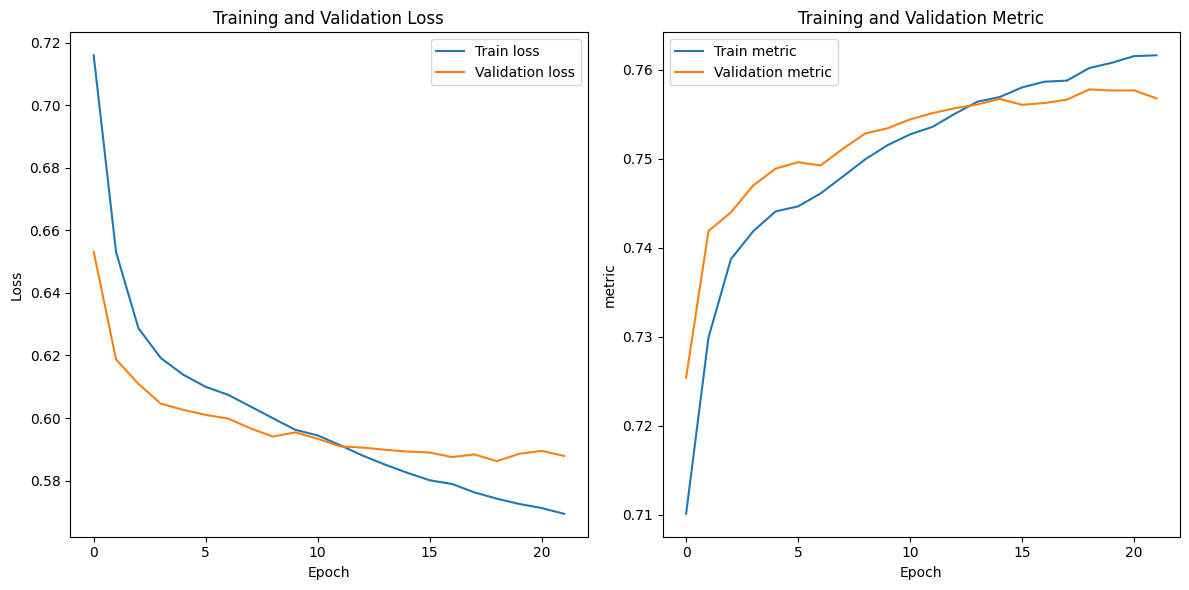

In [277]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Training and Validation Loss
axes[0].plot(train_loss_by_epoch, label="Train loss")
axes[0].plot(valid_loss_by_epoch, label="Validation loss")
axes[0].legend()
axes[0].set_title("Training and Validation Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")

# Training and Validation f1-score
axes[1].plot(train_metric_by_epoch, label="Train metric")
axes[1].plot(valid_metric_by_epoch, label="Validation metric")
axes[1].legend()
axes[1].set_title("Training and Validation Metric")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("metric")

plt.tight_layout()
plt.show()

Gráfico de la Pérdida (Training y Validation Loss)
Pérdida en entrenamiento: La pérdida de entrenamiento desciende de manera constante a lo largo de las épocas, lo que indica que el modelo está aprendiendo de los datos de entrenamiento y ajustándose bien a ellos.

Pérdida en validación: La pérdida de validación disminuye inicialmente, pero luego se estabiliza (alrededor de la época 10-12) y muestra algunas fluctuaciones. Esto podría indicar que el modelo ha dejado de mejorar significativamente en cuanto a generalización después de ese punto, pero no muestra señales claras de sobreajuste, ya que la pérdida de validación no está aumentando de manera importante.

La pérdida de validación es más baja que la pérdida de entrenamiento en varias épocas, lo que puede sugerir un caso donde los datos de validación son más fáciles de predecir o que hay un pequeño underfitting (subajuste). Sin embargo, dado que la diferencia no es grande y la pérdida de validación se estabiliza, parece estar funcionando de manera razonable.

Gráfico de la Métrica (Training y Validation Metric)
Métrica en entrenamiento: La métrica de entrenamiento mejora constantemente y alcanza un valor mayor a 0.75 al final del entrenamiento, lo cual sugiere que el modelo está aprendiendo correctamente a lo largo de las épocas.

Métrica en validación: La métrica de validación sube rápidamente al principio y se estabiliza alrededor de la época 10-12. Esto es consistente con lo que observamos en el gráfico de la pérdida de validación. Las fluctuaciones son bastante pequeñas, lo que sugiere que la generalización del modelo es estable.

Conclusión:
Generalización adecuada: El modelo parece estar generalizando bien, ya que las métricas de entrenamiento y validación están bastante alineadas y no hay un aumento claro en la pérdida de validación. No hay señales claras de sobreajuste.

Posible subajuste leve: La pérdida de validación es más baja que la de entrenamiento en varios puntos, lo que puede indicar que el modelo aún no está aprovechando todo el poder predictivo. Podría estar ocurriendo un pequeño subajuste en las últimas épocas, aunque las diferencias son mínimas.

Potencial de early stopping: A partir de la época 10-12, tanto la métrica como la pérdida de validación parecen estabilizarse. Implementar early stopping en este punto podría ser una buena opción para evitar entrenamientos innecesariamente largos y seleccionar el modelo que tiene el mejor rendimiento en validación.

#### Parte d

In [281]:
import torch.nn.functional as F

# Función para obtener usuarios similares
def suggest_similar_users(model, user_id, n=5):
    """
    Sugiere usuarios con un comportamiento de compras similar basado en embeddings.
    
    Args:
    - model: El modelo con embeddings entrenados.
    - user_id: ID del usuario objetivo.
    - n: Número de usuarios a sugerir (por defecto 5).
    
    Returns:
    - Lista de IDs de los usuarios más similares.
    """
    
    # Obtener el embedding del usuario objetivo
    user_embedding = model.embeddings1(torch.tensor([user_id]).to(model.embeddings1.weight.device))
    
    # Obtener todos los embeddings de usuarios
    all_user_embeddings = model.embeddings1.weight  # Esto tiene todos los embeddings entrenados
    
    # Calcular la similitud coseno entre el usuario objetivo y todos los demás usuarios
    similarities = F.cosine_similarity(user_embedding, all_user_embeddings)
    
    # Ordenar por similitud y obtener los índices de los usuarios más cercanos
    similar_users = torch.argsort(similarities, descending=True)
    
    # Filtrar el usuario objetivo para que no se sugiera a sí mismo
    similar_users = similar_users[similar_users != user_id]
    
    # Retornar los n usuarios más similares
    return similar_users[:n].cpu().numpy()

# Ejemplo de uso:
similar_users = suggest_similar_users(nnnetWithEmbeddings, user_id=4566, n=10)
print("Usuarios similares:", similar_users)

Usuarios similares: [3473  585 4432 2192 5518 5801 1916 5451 2228 4064]


#### Parte e

In [298]:
# Ahora el objetivo va a ser Purchase
y = datos['Purchase']
y = y.to_numpy()
print(y.shape)

y_train = y[train_idx]
y_valid = y[valid_idx]

(550068,)


In [299]:
train_ds_embeddings = MyDatasetWithEmbddings(x_train, user_idx_train, product_idx_train, y_train)
valid_ds_embeddings = MyDatasetWithEmbddings(x_valid, user_idx_valid, product_idx_valid, y_valid)

train_dataloader_emb = DataLoader(train_ds_embeddings, batch_size =64, shuffle= True)
valid_dataloader_emb = DataLoader(valid_ds_embeddings, batch_size=64)


In [312]:
from sklearn import metrics

class NNetWithEmbeddings(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embeddings1 = torch.nn.Embedding(num_embeddings=5891, embedding_dim=5)
        self.embeddings2 = torch.nn.Embedding(num_embeddings=3631, embedding_dim=5)
        self.linear_1 = torch.nn.Linear(in_features=81+5+5, out_features=128, bias=True)
        self.batch_norm1 = torch.nn.BatchNorm1d(128)
        self.relu_1 = torch.nn.ReLU()
        self.dropout_1 = torch.nn.Dropout(0.1)
        self.linear_2 = torch.nn.Linear(in_features=128, out_features=64, bias=True)
        self.batch_norm2 = torch.nn.BatchNorm1d(64)
        self.relu_2 = torch.nn.ReLU()
        self.dropout_2 = torch.nn.Dropout(0.1)
        self.linear_3 = torch.nn.Linear(in_features=64, out_features=1, bias=True)  # Regresión de un solo valor

    def forward(self, x, user_idx, product_idx):
        embeddings_outputs1 = self.embeddings1(user_idx)
        embeddings_outputs2 = self.embeddings2(product_idx)
        x = torch.cat([x, embeddings_outputs1, embeddings_outputs2], dim=1)
        x = self.linear_1(x)
        x = self.batch_norm1(x)
        x = self.relu_1(x)
        x = self.dropout_1(x)
        x = self.linear_2(x)
        x = self.batch_norm2(x)
        x = self.relu_2(x)
        x = self.dropout_2(x)
        x = self.linear_3(x)  # Salida continua
        return x


# Instanciamos la red y la copiamos al dispositivo
nnnetWithEmbeddings = NNetWithEmbeddings().to(device)

# Definimos la loss y el optimizador
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(nnnetWithEmbeddings.parameters(), lr=0.002)

epochs = 200
train_loss_by_epoch = []
valid_loss_by_epoch = []
train_metric_by_epoch = []
valid_metric_by_epoch = []

# Para implementar un early stopping
best_loss = float('inf')
patience = 5  # Número de épocas sin mejora antes de detener
patience_counter = 0

################################## Entrenamiento ####################################
for epoch in range(epochs):
    nnnetWithEmbeddings.train()
    epoch_loss = 0
    epoch_y, epoch_y_hat = [], []

    for i, data in enumerate(train_dataloader_emb):
        x_batch, embed_batch1, embed_batch2, y_batch = data
        x_batch = x_batch.to(device).float()
        embed_batch1 = embed_batch1.to(device).int()
        embed_batch2 = embed_batch2.to(device).int()
        y_batch = y_batch.to(device).float()  # Etiquetas como valores continuos

        optimizer.zero_grad()
        nnet_output = nnnetWithEmbeddings(x_batch, embed_batch1, embed_batch2)
        loss = loss_function(nnet_output.squeeze(), y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_y += list(y_batch.cpu().numpy())
        epoch_y_hat += list(nnet_output.squeeze().cpu().detach().numpy())  # Almacenar predicciones continuas

    # Calculo la media de la loss
    epoch_loss = epoch_loss / len(train_dataloader)
    train_loss_by_epoch.append(epoch_loss)

    # Cálculo la métrica de regresión (MSE en este caso)
    train_metric = metrics.mean_absolute_error(epoch_y, epoch_y_hat)
    train_metric_by_epoch.append(train_metric)

    ################################## Validación ##################################
    nnnetWithEmbeddings.eval()
    valid_loss = 0
    valid_y, valid_y_hat = [], []

    with torch.no_grad():
        for i, data in enumerate(valid_dataloader_emb):
            x_batch, embed_batch1, embed_batch2, y_batch = data
            x_batch = x_batch.to(device).float()
            embed_batch1 = embed_batch1.to(device).int()
            embed_batch2 = embed_batch2.to(device).int()
            y_batch = y_batch.to(device).float()  # Etiquetas deben ser continuas

            # Paso forward
            nnet_output = nnnetWithEmbeddings(x_batch, embed_batch1, embed_batch2)
            loss = loss_function(nnet_output.squeeze(), y_batch)
            valid_loss += loss.item()

            valid_y += list(y_batch.cpu().numpy())
            valid_y_hat += list(nnet_output.squeeze().cpu().detach().numpy())  # Almacenar predicciones continuas

    valid_loss = valid_loss / len(valid_dataloader)
    valid_loss_by_epoch.append(valid_loss)

    # Cálculo la métrica de regresión (MSE)
    valid_metric = metrics.mean_absolute_error(valid_y, valid_y_hat)
    valid_metric_by_epoch.append(valid_metric)

    print(f"Epoch {epoch} | Train/Valid loss: {epoch_loss:.4f} / {valid_loss:.4f} | "
          f"Train/Valid MAE: {train_metric:.4f} / {valid_metric:.4f}")

    # Early stopping
    if np.round(valid_loss, 4) < best_loss:
        best_loss = np.round(valid_loss, 4)
        patience_counter = 0  # Reinicia el contador
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Detenido por early stopping.")
        break


Epoch 0 | Train/Valid loss: 38977996.3695 / 7876462.3572 | Train/Valid MAE: 4762.7354 / 2119.1853
Epoch 1 | Train/Valid loss: 7675250.8116 / 6393143.6376 | Train/Valid MAE: 2083.7444 / 1876.5327
Epoch 2 | Train/Valid loss: 6759436.5563 / 6124812.6010 | Train/Valid MAE: 1929.4698 / 1820.8113
Epoch 3 | Train/Valid loss: 6593833.4979 / 6093592.6078 | Train/Valid MAE: 1904.7083 / 1816.2671
Epoch 4 | Train/Valid loss: 6470081.8807 / 6050373.6866 | Train/Valid MAE: 1884.3586 / 1814.6344
Epoch 5 | Train/Valid loss: 6387964.9604 / 5979512.6490 | Train/Valid MAE: 1871.6165 / 1791.3258
Epoch 6 | Train/Valid loss: 6310473.8043 / 5954240.7238 | Train/Valid MAE: 1858.2242 / 1789.7207
Epoch 7 | Train/Valid loss: 6250078.8241 / 5939901.4512 | Train/Valid MAE: 1848.9756 / 1787.4946
Epoch 8 | Train/Valid loss: 6182730.2089 / 5935845.8360 | Train/Valid MAE: 1838.3813 / 1796.8148
Epoch 9 | Train/Valid loss: 6131580.2839 / 5901708.6605 | Train/Valid MAE: 1830.5248 / 1771.3389
Epoch 10 | Train/Valid loss: 

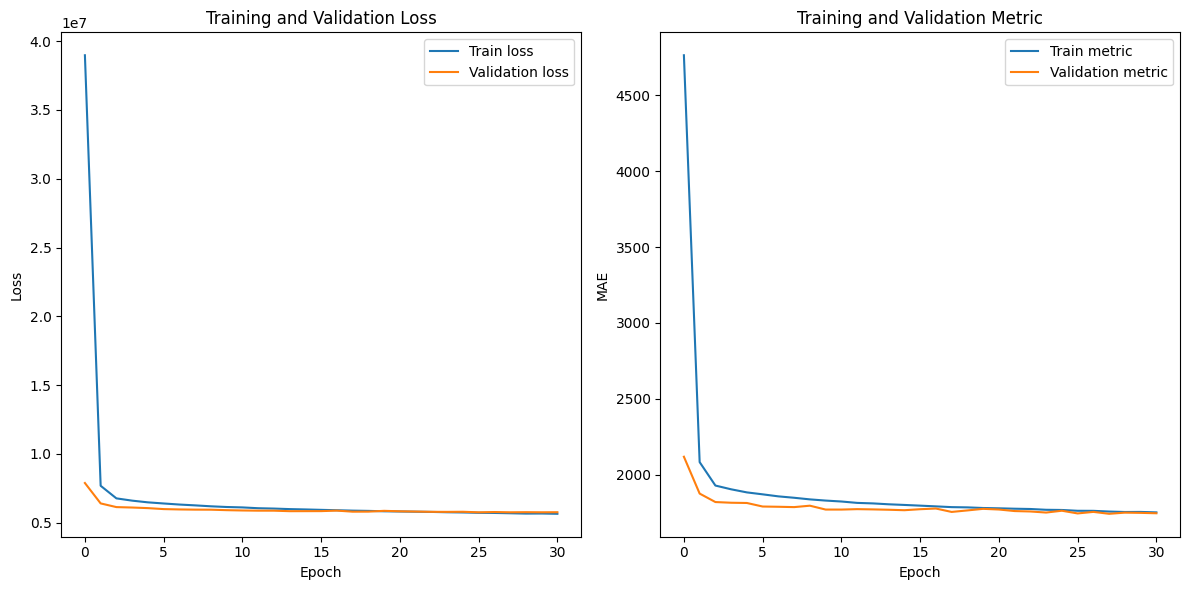

In [314]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Training and Validation Loss
axes[0].plot(train_loss_by_epoch, label="Train loss")
axes[0].plot(valid_loss_by_epoch, label="Validation loss")
axes[0].legend()
axes[0].set_title("Training and Validation Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")

# Training and Validation f1-score
axes[1].plot(train_metric_by_epoch, label="Train metric")
axes[1].plot(valid_metric_by_epoch, label="Validation metric")
axes[1].legend()
axes[1].set_title("Training and Validation Metric")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("MAE")

plt.tight_layout()
plt.show()

# Parte 2.a

Implemente una arquitectura de red neuronal basada en CNN para identificar del dataset fashion MNIST las 10 clases del mismo. Sobre dicho modelo, realize una exploración de 5 variantes distintas (que se desprenden del modelo propuesto) variando alguno (o varios) de los siguientes hiperparámetros:
- numero de capas.
- numero de kernels.
- tamaño de kernels.


Evalue la evolución de la función de perdida y la accuracy (para train y test) para cada modelo en una gráfica con las curvas de los 5 modelos propuestos. Compare también el tiempo de entrenamiento y peso (tamaño) de cada modelo. Aplique técnicas de regularización para evitar overfitting. Elija el modelo que considera mejor y justifique.
Entregables:
 - Grafica comparativa de función de perdida vs epochs para los 5 modelos.
 - Grafica comparativa de función de accuracy vs epochs para los 5 modelos.
 - Tabla comparativa (o grafico de barras) del tiempo de entrenamiento y pesos de cada modelo.
 - Justificación del modelo elegio (qué consideró para elegir el modelo y bajo qué criterio).



In [323]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

AttributeError: partially initialized module 'torchvision' has no attribute 'extension' (most likely due to a circular import)

In [322]:
# Download train data from open datasets.
train_data= datasets.FashionMNIST(root='data', train=True, download=True, transform=ToTensor(),)

# Download test data from open datsets.
test_data=datasets.FashionMNIST(root='data', train=False, download=True, transform=ToTensor(),)


NameError: name 'datasets' is not defined

In [ ]:
import matplotlib.pyplot as plt

labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (10,10))
cols, rows = 3, 3

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(train_data), size = (1,)).item()
    image, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

# Parte 2.b

Empleando el modelo entrenado y elegido por Ud. en el punto anterior, realice transfer learning para procesar las imágenes del dataset MNIST (los números) **e identificar los números mayores o menores a 4,5**.
Para el entrenamiento emplee solamente 20.000 muestras del set de entrenamiento y valide con el set de testeo. Al reducir el train set, mantenga equilibrada la distribución de las clases.

Elija la estrategia de transfer learning acorde a los visto en la teoría y justifique su elección.

Compare las curvas de entrenamiento y accurracy empleando transfer learning o usando la arquitectura elejida en el punto anterior pero entrenando desde cero.
Entregables:
- Estrategia elegida y su justificación.
- Grafica comparativa de función de perdida vs epochs para el modelo con transfer learning y sin transfer learning.
- Grafica comparativa de función de accuracy vs epochs para el modelo con transfer learning y sin transfer learning.
- Comentarios sobre las curvas graficadas.
